In [26]:
import networkx as nx
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances


# Define the required functions
def retrieve_bidirectional_edges(g: nx.DiGraph, tracks_df: pd.DataFrame, out_filename: str) -> nx.Graph:
    undirected_g = nx.Graph()
    
    artist_names = dict(zip(tracks_df['artist_id'], tracks_df['artist_name']))
    
    for u, v in g.edges():
        if g.has_edge(v, u):
            undirected_g.add_edge(u, v)
            undirected_g.nodes[u]['name'] = artist_names.get(u, u)
            undirected_g.nodes[v]['name'] = artist_names.get(v, v)
    
    nx.write_graphml(undirected_g, out_filename)
    return undirected_g


def prune_low_degree_nodes(g: nx.Graph, min_degree: int, out_filename: str) -> nx.Graph:
    """
    Prune a graph by removing nodes with degree < min_degree.

    :param g: a networkx graph.
    :param min_degree: lower bound value for the degree.
    :param out_filename: name of the file that will be saved.
    :return: a pruned networkx graph.
    """
    nodes_to_keep = [node for node, degree in dict(g.degree()).items() if degree >= min_degree]
    pruned_g = g.subgraph(nodes_to_keep).copy()

    nx.write_graphml(pruned_g, out_filename)
    return pruned_g


def prune_low_weight_edges(g: nx.Graph, min_weight: float = None, min_percentile: int = None, out_filename: str = None) -> nx.Graph:
    """
    Prune a graph by removing edges with weight < threshold. Threshold can be specified as a value or as a percentile.
    """
    if (min_weight is None and min_percentile is None) or (min_weight is not None and min_percentile is not None):
        raise ValueError("Specify either min_weight or min_percentile, but not both.")
    
    if min_percentile is not None:
        weights = [data['weight'] for u, v, data in g.edges(data=True)]
        threshold = pd.Series(weights).quantile(min_percentile / 100)
    else:
        threshold = min_weight
    
    edges_to_keep = [(u, v) for u, v, data in g.edges(data=True) if data['weight'] >= threshold]
    pruned_g = g.edge_subgraph(edges_to_keep).copy()
    
    # Remove nodes with zero degree
    zero_degree_nodes = [node for node, degree in dict(pruned_g.degree()).items() if degree == 0]
    pruned_g.remove_nodes_from(zero_degree_nodes)
    
    if out_filename:
        nx.write_graphml(pruned_g, out_filename)
    return pruned_g



def compute_mean_audio_features(tracks_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute the mean audio features for tracks of the same artist.

    :param tracks_df: tracks dataframe (with audio features per each track).
    :return: artist dataframe (with mean audio features per each artist).
    """
    # Columns to compute mean for (excluding non-relevant numeric columns)
    audio_feature_columns = ['danceability', 'energy', 'loudness', 'speechiness',
                             'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
    
    # Group by artist_id and artist_name, then compute mean for relevant columns
    mean_features_df = tracks_df.groupby(['artist_id', 'artist_name'])[audio_feature_columns].mean().reset_index()
    
    return mean_features_df

def create_similarity_graph(artist_audio_features_df: pd.DataFrame, similarity: str, out_filename: str = None) -> nx.Graph:
    feature_columns = artist_audio_features_df.select_dtypes(include='number').columns
    
    if similarity == "cosine":
        similarity_matrix = cosine_similarity(artist_audio_features_df[feature_columns])
    elif similarity == "euclidean":
        similarity_matrix = euclidean_distances(artist_audio_features_df[feature_columns])
        similarity_matrix = 1 / (1 + similarity_matrix)
    else:
        raise ValueError("Unknown similarity metric. Use 'cosine' or 'euclidean'.")
    
    similarity_graph = nx.Graph()
    num_artists = artist_audio_features_df.shape[0]
    
    for i in range(num_artists):
        for j in range(i + 1, num_artists):
            similarity_graph.add_edge(artist_audio_features_df.iloc[i, 0], artist_audio_features_df.iloc[j, 0],
                                      weight=similarity_matrix[i, j])
            similarity_graph.nodes[artist_audio_features_df.iloc[i, 0]]['name'] = artist_audio_features_df.iloc[i, 1]
            similarity_graph.nodes[artist_audio_features_df.iloc[j, 0]]['name'] = artist_audio_features_df.iloc[j, 1]
    
    if out_filename:
        nx.write_graphml(similarity_graph, out_filename)
    
    return similarity_graph

In [27]:
import matplotlib.pyplot as plt

def visualize_graph(graph, title):
    pos = nx.spring_layout(graph)
    plt.figure(figsize=(10, 10))
    nx.draw(graph, pos, with_labels=True, node_size=50, font_size=8)
    plt.title(title)
    plt.show()

def print_graph_metrics(graph, name):
    print(f"Metrics for {name}:")
    if nx.is_directed(graph):
        print(f"Strongly connected components: {nx.number_strongly_connected_components(graph)}")
        print(f"Weakly connected components: {nx.number_weakly_connected_components(graph)}")
    else:
        print(f"Connected components: {nx.number_connected_components(graph)}")

def find_most_least_similar_artists(graph):
    edges = sorted(graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
    most_similar = edges[0]
    least_similar = edges[-1]
    return most_similar, least_similar

def find_most_least_similar_to_all(graph):
    avg_weights = {node: sum(data['weight'] for _, _, data in graph.edges(node, data=True)) / graph.degree(node) 
                   for node in graph.nodes()}
    most_similar = max(avg_weights, key=avg_weights.get)
    least_similar = min(avg_weights, key=avg_weights.get)
    return most_similar, least_similar

                  artist_id     artist_name  danceability    energy  loudness  \
0    00FQb4jTyendYWaN8pK0wa    Lana Del Rey      0.418700  0.521200 -8.291200   
1    06HL4z0CvFAxyc27GXpf02    Taylor Swift      0.567400  0.521500 -8.928900   
2    0C8ZW7ezQVs4URX5aX7Kqx            Kygo      0.640000  0.533000 -6.596000   
3    0C8ZW7ezQVs4URX5aX7Kqx            Rema      0.801000  0.806000 -5.206000   
4    0C8ZW7ezQVs4URX5aX7Kqx    Selena Gomez      0.659625  0.599000 -5.861875   
..                      ...             ...           ...       ...       ...   
338  7gbmX8SsfjEjxDMzBi1ZOL     Kevin Jonas      0.605000  0.846000 -4.581000   
339  7n2wHs1TKAczGzO7Dd2rGr    Shawn Mendes      0.641900  0.721200 -5.284500   
340  7nU4hB040gTmHm45YYMvqc  Hannah Montana      0.573000  0.852800 -3.798400   
341  7rPQ2z1ji1ctJ6oGYBAo6M    Emily Osment      0.600333  0.719889 -5.810889   
342  7rPQ2z1ji1ctJ6oGYBAo6M   Mitchel Musso      0.725000  0.836000 -5.885000   

     speechiness  acousticn

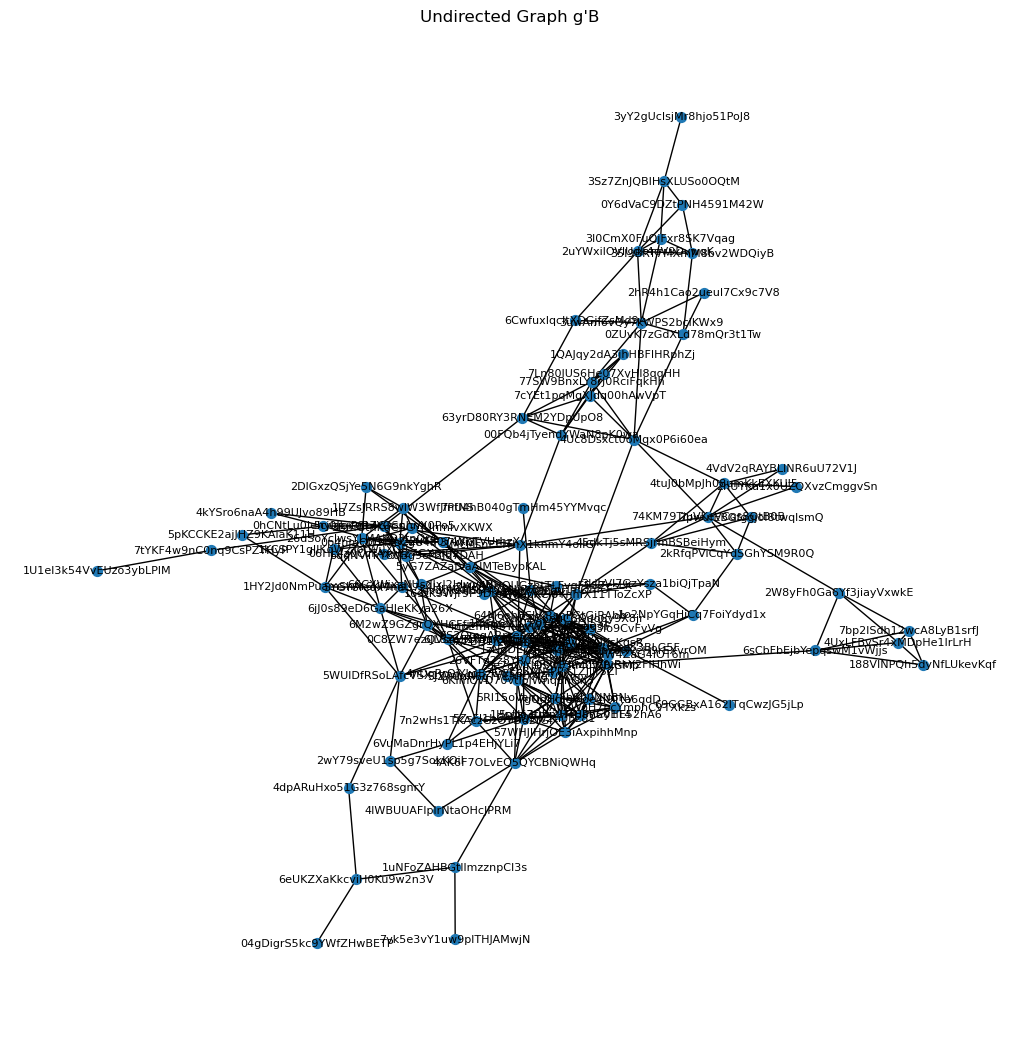

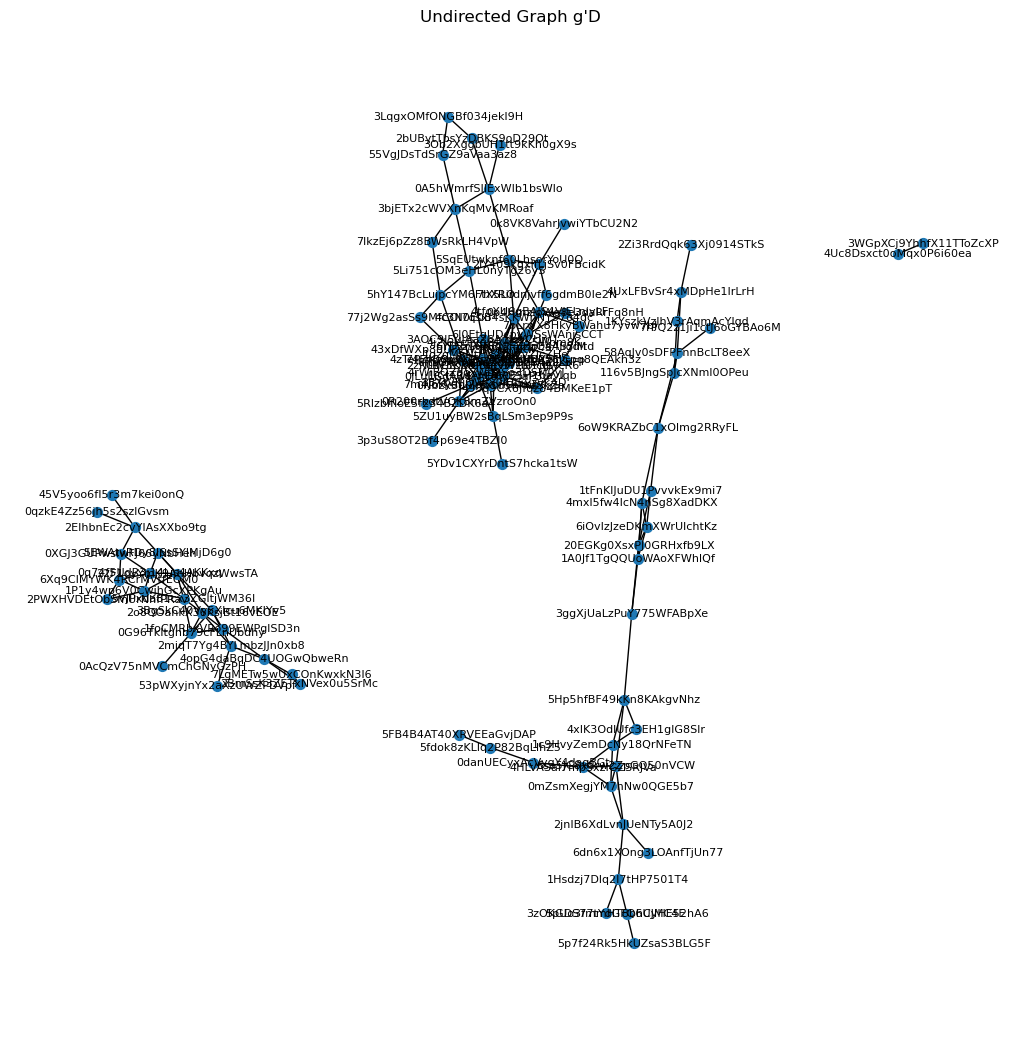

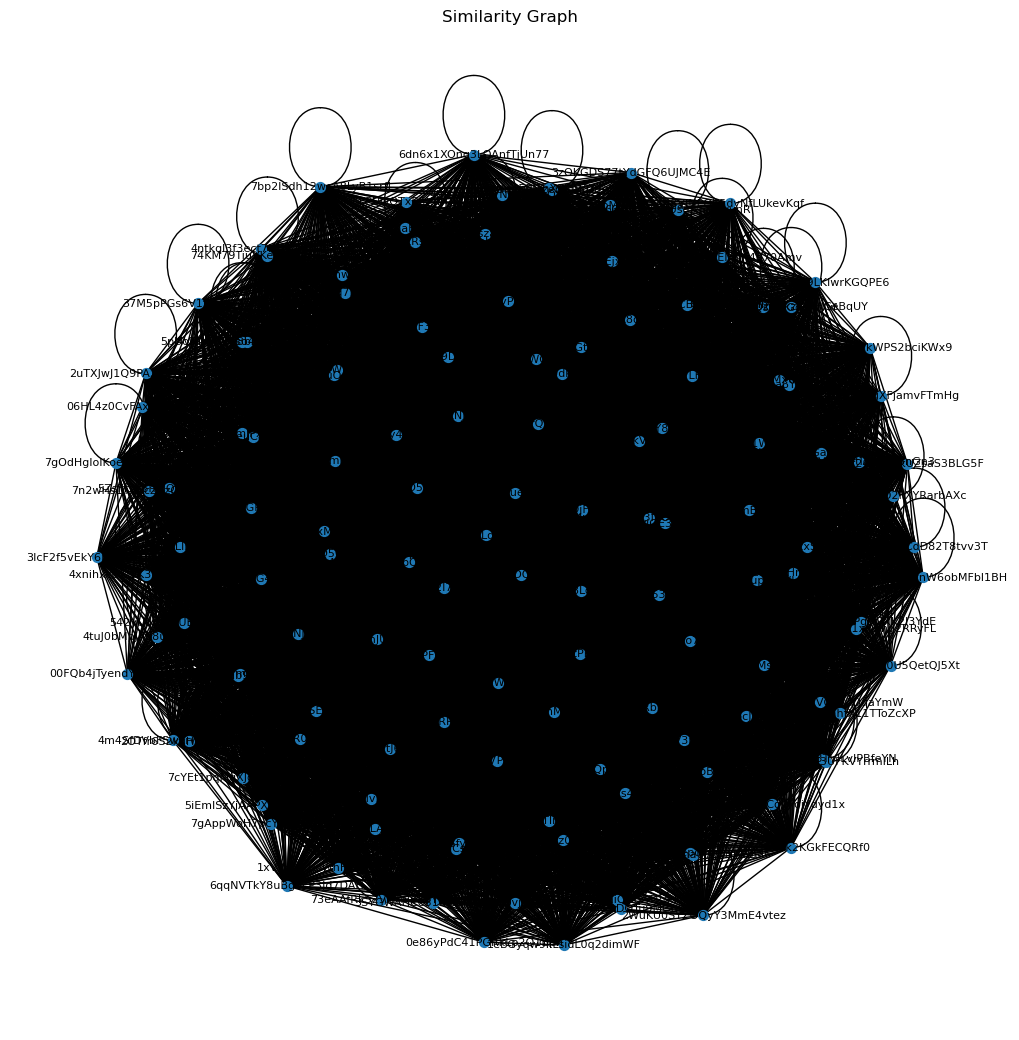

Metrics for Undirected Graph g'B:
Connected components: 1
Metrics for Undirected Graph g'D:
Connected components: 4
Metrics for Similarity Graph:
Connected components: 1
Most similar artists: Zac Efron and Zac Efron with weight 1.0
Least similar artists: Victorious Cast and Phillipa Soo with weight 0.9882851155513083
Artist most similar to all others: Hailee Steinfeld
Artist least similar to all others: Phillipa Soo


In [28]:
def main():
    # Load the graphs
    gB = nx.read_graphml('/Users/marino/Documents/GitHub/Analysis-of-music-networks/P1: Acquisition and storage of data/gB.graphml')
    gD = nx.read_graphml('/Users/marino/Documents/GitHub/Analysis-of-music-networks/P1: Acquisition and storage of data/gD.graphml')

    # Load tracks data 
    tracks_df = pd.read_csv('/Users/marino/Documents/GitHub/Analysis-of-music-networks/P1: Acquisition and storage of data/songs.csv')
    tracks_df = pd.DataFrame(tracks_df)

    # Task 6(a): Generate undirected graphs g'B and g'D
    gB_undirected = retrieve_bidirectional_edges(gB, tracks_df, '/Users/marino/Documents/GitHub/Analysis-of-music-networks/P2: Data Preprocessing/gBp.graphml')
    gD_undirected = retrieve_bidirectional_edges(gD, tracks_df, '/Users/marino/Documents/GitHub/Analysis-of-music-networks/P2: Data Preprocessing/gDp.graphml')

    # Task 6(b): Compute mean audio features
    mean_audio_features_df = compute_mean_audio_features(tracks_df)
    print(mean_audio_features_df)

    # Create similarity graph
    similarity_graph = create_similarity_graph(mean_audio_features_df, 'cosine', '/Users/marino/Documents/GitHub/Analysis-of-music-networks/P2: Data Preprocessing/gw.graphml')
    print("Graphs have been processed and saved successfully.")

    # Visualize the graphs
    visualize_graph(gB_undirected, "Undirected Graph g'B")
    visualize_graph(gD_undirected, "Undirected Graph g'D")
    visualize_graph(similarity_graph, "Similarity Graph")

    # Print metrics for each graph
    print_graph_metrics(gB_undirected, "Undirected Graph g'B")
    print_graph_metrics(gD_undirected, "Undirected Graph g'D")
    print_graph_metrics(similarity_graph, "Similarity Graph")

    # Find and print the most and least similar artists
    most_similar, least_similar = find_most_least_similar_artists(similarity_graph)
    print(f"Most similar artists: {similarity_graph.nodes[most_similar[0]]['name']} and {similarity_graph.nodes[most_similar[1]]['name']} with weight {most_similar[2]['weight']}")
    print(f"Least similar artists: {similarity_graph.nodes[least_similar[0]]['name']} and {similarity_graph.nodes[least_similar[1]]['name']} with weight {least_similar[2]['weight']}")

    # Find and print the artist most and least similar to all others
    most_similar_to_all, least_similar_to_all = find_most_least_similar_to_all(similarity_graph)
    print(f"Artist most similar to all others: {similarity_graph.nodes[most_similar_to_all]['name']}")
    print(f"Artist least similar to all others: {similarity_graph.nodes[least_similar_to_all]['name']}")

if __name__ == "__main__":
    main()

Mean audio features:
                artist_id   artist_name  danceability  energy  loudness  \
0  00FQb4jTyendYWaN8pK0wa  Lana Del Rey      0.418700  0.5212 -8.291200   
1  06HL4z0CvFAxyc27GXpf02  Taylor Swift      0.567400  0.5215 -8.928900   
2  0C8ZW7ezQVs4URX5aX7Kqx          Kygo      0.640000  0.5330 -6.596000   
3  0C8ZW7ezQVs4URX5aX7Kqx          Rema      0.801000  0.8060 -5.206000   
4  0C8ZW7ezQVs4URX5aX7Kqx  Selena Gomez      0.659625  0.5990 -5.861875   

   speechiness  acousticness  instrumentalness  liveness   valence       tempo  
0     0.041640      0.422970          0.060700   0.14020  0.238290  115.417400  
1     0.086530      0.352330          0.000268   0.12884  0.341700  131.402200  
2     0.070600      0.119000          0.000000   0.08640  0.515000   99.968000  
3     0.038100      0.382000          0.000669   0.11400  0.802000  106.999000  
4     0.048813      0.138591          0.000008   0.14150  0.439787  115.246125  
Graphs have been processed and saved succe

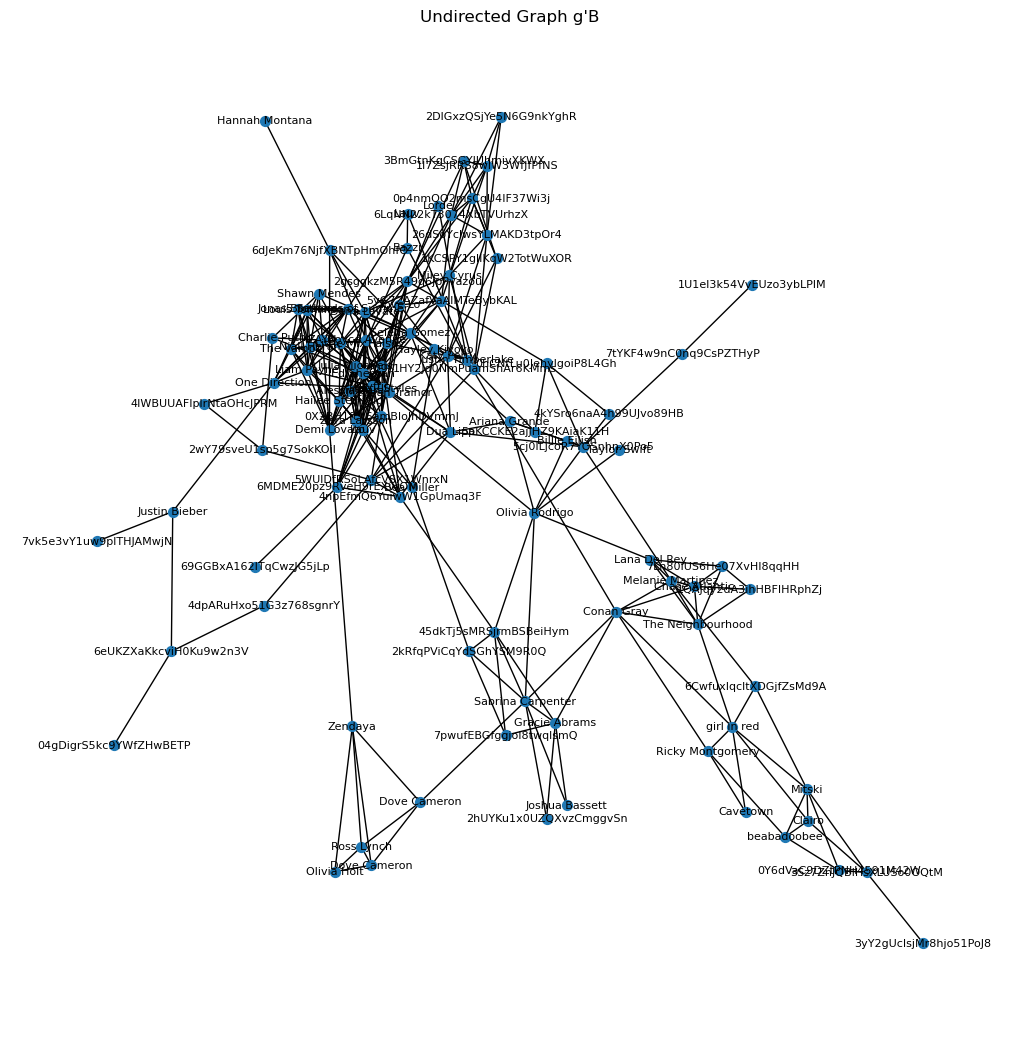

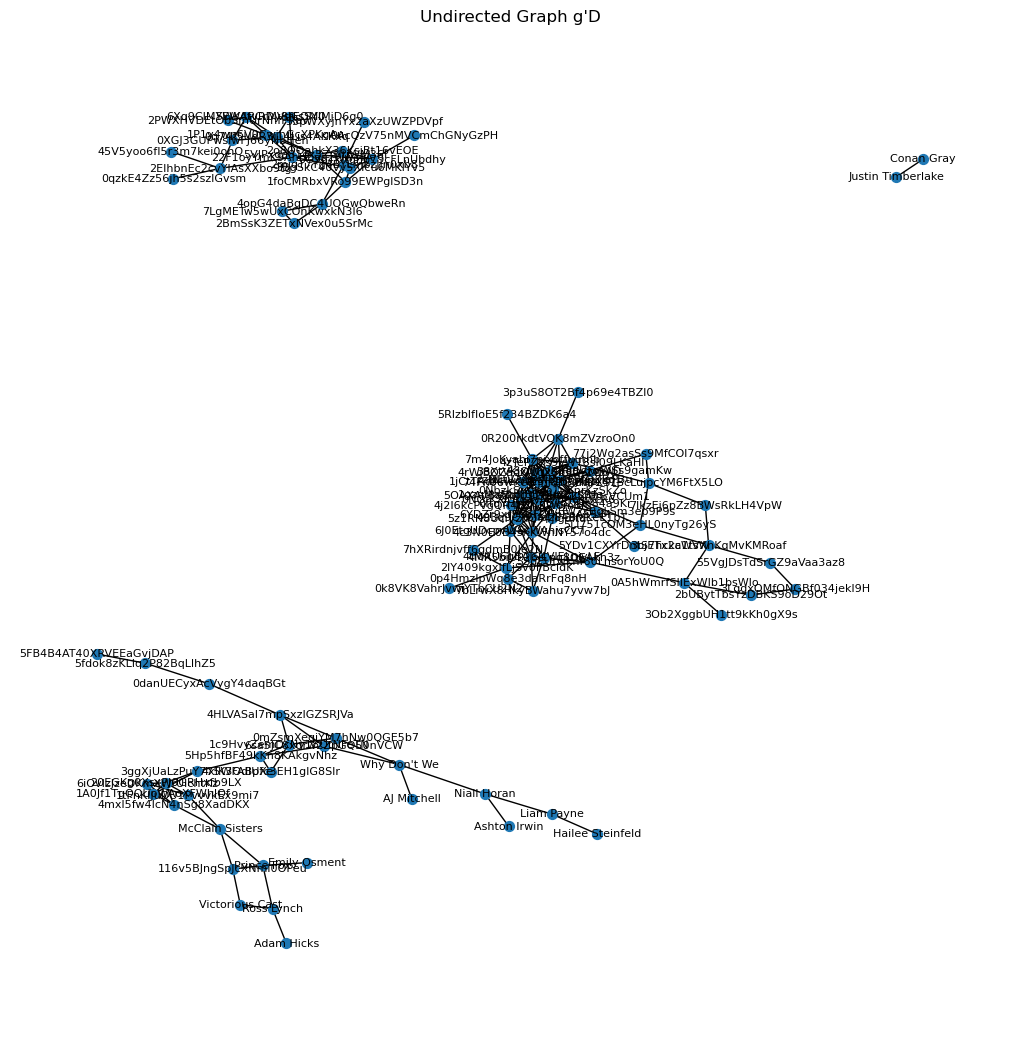

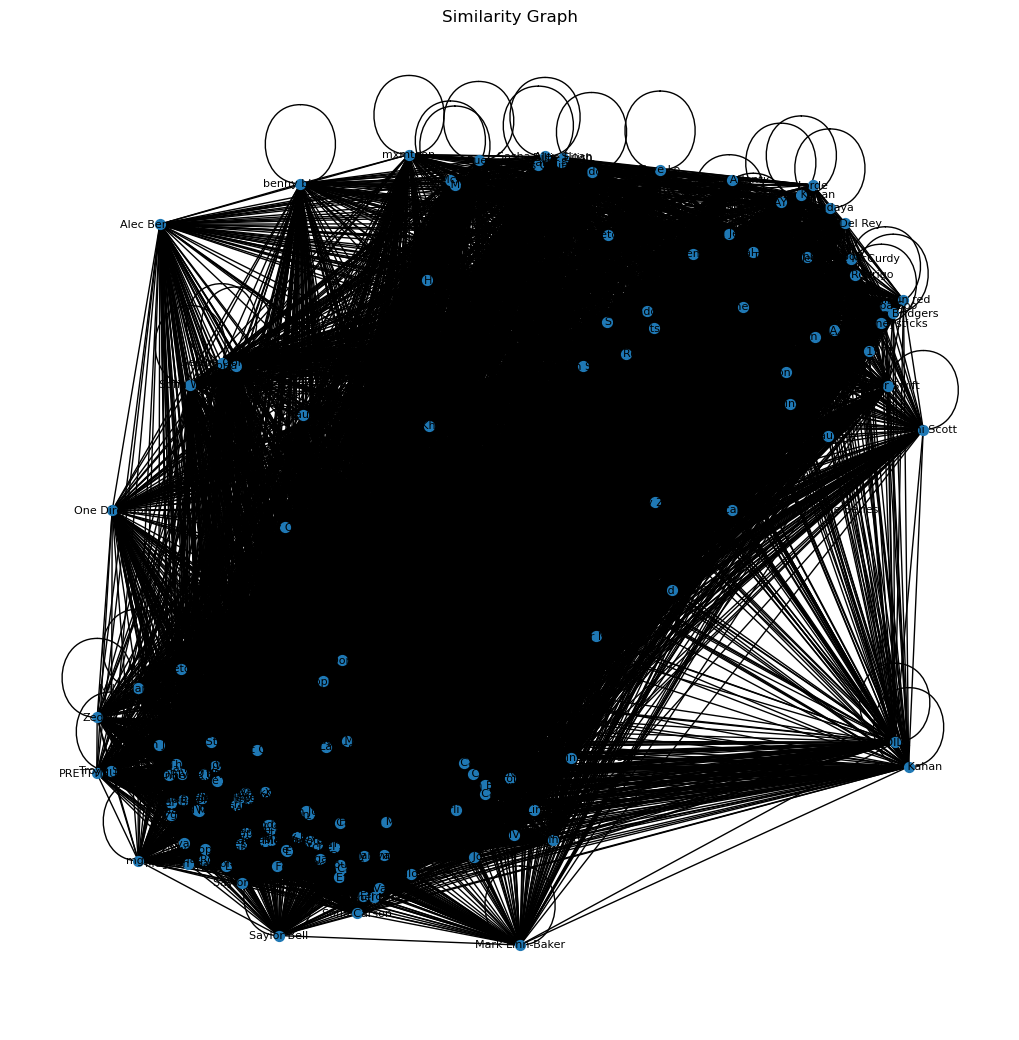

Metrics for Undirected Graph g'B:
Connected components: 1
Metrics for Undirected Graph g'D:
Connected components: 4
Metrics for Similarity Graph:
Connected components: 1
Debug: Most similar edge weight: 0.6540944631138054
Debug: Least similar edge weight: 0.39818513805214834
Most similar artists: Lana Del Rey and Taylor Swift with weight 0.6540944631138054
Least similar artists: Hannah Montana and Mitchel Musso with weight 0.39818513805214834
Artist most similar to all others: Lindsay Lohan
Artist least similar to all others: mxmtoon


In [39]:
import networkx as nx
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def retrieve_bidirectional_edges(g: nx.DiGraph, tracks_df: pd.DataFrame, out_filename: str) -> nx.Graph:
    undirected_g = nx.Graph()
    artist_names = dict(zip(tracks_df['artist_id'], tracks_df['artist_name']))
    
    for u, v in g.edges():
        if g.has_edge(v, u):
            undirected_g.add_edge(u, v)
            undirected_g.nodes[u]['name'] = artist_names.get(u, u)
            undirected_g.nodes[v]['name'] = artist_names.get(v, v)
    
    nx.write_graphml(undirected_g, out_filename)
    return undirected_g

def prune_low_degree_nodes(g: nx.Graph, min_degree: int, out_filename: str) -> nx.Graph:
    nodes_to_keep = [node for node, degree in dict(g.degree()).items() if degree >= min_degree]
    pruned_g = g.subgraph(nodes_to_keep).copy()
    nx.write_graphml(pruned_g, out_filename)
    return pruned_g

def prune_low_weight_edges(g: nx.Graph, min_weight: float = None, min_percentile: int = None, out_filename: str = None) -> nx.Graph:
    if (min_weight is None and min_percentile is None) or (min_weight is not None and min_percentile is not None):
        raise ValueError("Specify either min_weight or min_percentile, but not both.")
    
    if min_percentile is not None:
        weights = [data['weight'] for u, v, data in g.edges(data=True)]
        threshold = pd.Series(weights).quantile(min_percentile / 100)
    else:
        threshold = min_weight
    
    edges_to_keep = [(u, v) for u, v, data in g.edges(data=True) if data['weight'] >= threshold]
    pruned_g = g.edge_subgraph(edges_to_keep).copy()
    
    zero_degree_nodes = [node for node, degree in dict(pruned_g.degree()).items() if degree == 0]
    pruned_g.remove_nodes_from(zero_degree_nodes)
    
    if out_filename:
        nx.write_graphml(pruned_g, out_filename)
    return pruned_g

def compute_mean_audio_features(tracks_df: pd.DataFrame) -> pd.DataFrame:
    audio_feature_columns = ['danceability', 'energy', 'loudness', 'speechiness',
                             'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
    
    mean_features_df = tracks_df.groupby(['artist_id', 'artist_name'])[audio_feature_columns].mean().reset_index()
    return mean_features_df

def create_similarity_graph(artist_audio_features_df: pd.DataFrame, similarity: str, out_filename: str = None) -> nx.Graph:
    feature_columns = artist_audio_features_df.select_dtypes(include='number').columns
    
    # Normalize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(artist_audio_features_df[feature_columns])
    
    if similarity == "cosine":
        similarity_matrix = cosine_similarity(scaled_features)
    elif similarity == "euclidean":
        similarity_matrix = euclidean_distances(scaled_features)
        similarity_matrix = 1 / (1 + similarity_matrix)
    else:
        raise ValueError("Unknown similarity metric. Use 'cosine' or 'euclidean'.")
    
    similarity_graph = nx.Graph()
    num_artists = artist_audio_features_df.shape[0]
    
    for i in range(num_artists):
        for j in range(i + 1, num_artists):
            similarity_graph.add_edge(artist_audio_features_df.iloc[i, 0], artist_audio_features_df.iloc[j, 0],
                                      weight=similarity_matrix[i, j])
            similarity_graph.nodes[artist_audio_features_df.iloc[i, 0]]['name'] = artist_audio_features_df.iloc[i, 1]
            similarity_graph.nodes[artist_audio_features_df.iloc[j, 0]]['name'] = artist_audio_features_df.iloc[j, 1]
    
    if out_filename:
        nx.write_graphml(similarity_graph, out_filename)
    
    return similarity_graph

def visualize_graph(graph, title):
    pos = nx.spring_layout(graph)
    plt.figure(figsize=(10, 10))
    labels = nx.get_node_attributes(graph, 'name')
    nx.draw(graph, pos, labels=labels, with_labels=True, node_size=50, font_size=8)
    plt.title(title)
    plt.show()

def print_graph_metrics(graph, name):
    print(f"Metrics for {name}:")
    if nx.is_directed(graph):
        print(f"Strongly connected components: {nx.number_strongly_connected_components(graph)}")
        print(f"Weakly connected components: {nx.number_weakly_connected_components(graph)}")
    else:
        print(f"Connected components: {nx.number_connected_components(graph)}")

def find_most_least_similar_artists(graph):
    edges = sorted((u, v, d) for u, v, d in graph.edges(data=True) if u != v)  # Exclude self-loops
    most_similar = edges[0]
    least_similar = edges[-1]
    print(f"Debug: Most similar edge weight: {most_similar[2]['weight']}")
    print(f"Debug: Least similar edge weight: {least_similar[2]['weight']}")
    return most_similar, least_similar

def find_most_least_similar_to_all(graph):
    avg_weights = {node: sum(data['weight'] for _, _, data in graph.edges(node, data=True)) / graph.degree(node) 
                   for node in graph.nodes()}
    most_similar = max(avg_weights, key=avg_weights.get)
    least_similar = min(avg_weights, key=avg_weights.get)
    return most_similar, least_similar

def main():
    # Load the graphs
    gB = nx.read_graphml('/Users/marino/Documents/GitHub/Analysis-of-music-networks/P1: Acquisition and storage of data/gB.graphml')
    gD = nx.read_graphml('/Users/marino/Documents/GitHub/Analysis-of-music-networks/P1: Acquisition and storage of data/gD.graphml')

    # Load tracks data 
    tracks_df = pd.read_csv('/Users/marino/Documents/GitHub/Analysis-of-music-networks/P1: Acquisition and storage of data/songs.csv')
    tracks_df = pd.DataFrame(tracks_df)

    # Task 6(a): Generate undirected graphs g'B and g'D
    gB_undirected = retrieve_bidirectional_edges(gB, tracks_df, '/Users/marino/Documents/GitHub/Analysis-of-music-networks/P2: Data Preprocessing/gBp.graphml')
    gD_undirected = retrieve_bidirectional_edges(gD, tracks_df, '/Users/marino/Documents/GitHub/Analysis-of-music-networks/P2: Data Preprocessing/gDp.graphml')

    # Task 6(b): Compute mean audio features
    mean_audio_features_df = compute_mean_audio_features(tracks_df)
    print("Mean audio features:")
    print(mean_audio_features_df.head())

    # Create similarity graph
    similarity_graph = create_similarity_graph(mean_audio_features_df, 'cosine', '/Users/marino/Documents/GitHub/Analysis-of-music-networks/P2: Data Preprocessing/gw.graphml')
    print("Graphs have been processed and saved successfully.")

    # Visualize the graphs
    visualize_graph(gB_undirected, "Undirected Graph g'B")
    visualize_graph(gD_undirected, "Undirected Graph g'D")
    visualize_graph(similarity_graph, "Similarity Graph")

    # Print metrics for each graph
    print_graph_metrics(gB_undirected, "Undirected Graph g'B")
    print_graph_metrics(gD_undirected, "Undirected Graph g'D")
    print_graph_metrics(similarity_graph, "Similarity Graph")

    # Find and print the most and least similar artists
    most_similar, least_similar = find_most_least_similar_artists(similarity_graph)
    print(f"Most similar artists: {similarity_graph.nodes[most_similar[0]]['name']} and {similarity_graph.nodes[most_similar[1]]['name']} with weight {most_similar[2]['weight']}")
    print(f"Least similar artists: {similarity_graph.nodes[least_similar[0]]['name']} and {similarity_graph.nodes[least_similar[1]]['name']} with weight {least_similar[2]['weight']}")

    # Find and print the artist most and least similar to all others
    most_similar_to_all, least_similar_to_all = find_most_least_similar_to_all(similarity_graph)
    print(f"Artist most similar to all others: {similarity_graph.nodes[most_similar_to_all]['name']}")
    print(f"Artist least similar to all others: {similarity_graph.nodes[least_similar_to_all]['name']}")

if __name__ == "__main__":
    main()


In [2]:
import networkx as nx
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import matplotlib.pyplot as plt

# Define the required functions
def retrieve_bidirectional_edges(g: nx.DiGraph, tracks_df: pd.DataFrame, out_filename: str) -> nx.Graph:
    undirected_g = nx.Graph()
    
    artist_names = dict(zip(tracks_df['artist_id'], tracks_df['artist_name']))
    
    for u, v in g.edges():
        if g.has_edge(v, u):
            undirected_g.add_edge(u, v)
    
    # Ensure every node has the 'name' attribute set properly
    for node in undirected_g.nodes():
        undirected_g.nodes[node]['name'] = artist_names.get(node, node)
    
    # Save the graph to a GraphML file with the artist_name instead of artist_id
    nx.write_graphml(undirected_g, out_filename)
    
    return undirected_g


def prune_low_weight_edges(g: nx.Graph, min_weight: float = None, min_percentile: int = None, out_filename: str = None) -> nx.Graph:
    if (min_weight is None and min_percentile is None) or (min_weight is not None and min_percentile is not None):
        raise ValueError("Specify either min_weight or min_percentile, but not both.")
    
    if min_percentile is not None:
        weights = [data['weight'] for u, v, data in g.edges(data=True)]
        threshold = pd.Series(weights).quantile(min_percentile / 100)
    else:
        threshold = min_weight
    
    edges_to_keep = [(u, v) for u, v, data in g.edges(data=True) if data['weight'] >= threshold]
    pruned_g = g.edge_subgraph(edges_to_keep).copy()
    
    zero_degree_nodes = [node for node, degree in dict(pruned_g.degree()).items() if degree == 0]
    pruned_g.remove_nodes_from(zero_degree_nodes)
    
    if out_filename:
        nx.write_graphml(pruned_g, out_filename)
    return pruned_g

def compute_mean_audio_features(tracks_df: pd.DataFrame) -> pd.DataFrame:
    audio_feature_columns = ['danceability', 'energy', 'loudness', 'speechiness',
                             'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
    
    mean_features_df = tracks_df.groupby(['artist_id', 'artist_name'])[audio_feature_columns].mean().reset_index()
    return mean_features_df

def create_similarity_graph(artist_audio_features_df: pd.DataFrame, similarity: str, out_filename: str = None) -> nx.Graph:
    feature_columns = artist_audio_features_df.select_dtypes(include='number').columns
    
    if similarity == "cosine":
        similarity_matrix = cosine_similarity(artist_audio_features_df[feature_columns])
    elif similarity == "euclidean":
        similarity_matrix = euclidean_distances(artist_audio_features_df[feature_columns])
        similarity_matrix = 1 / (1 + similarity_matrix)
    else:
        raise ValueError("Unknown similarity metric. Use 'cosine' or 'euclidean'.")
    
    similarity_graph = nx.Graph()
    num_artists = artist_audio_features_df.shape[0]
    
    for i in range(num_artists):
        for j in range(i + 1, num_artists):
            if i != j:  # Avoid self-loops
                similarity_graph.add_edge(artist_audio_features_df.iloc[i, 0], artist_audio_features_df.iloc[j, 0],
                                          weight=similarity_matrix[i, j])
                similarity_graph.nodes[artist_audio_features_df.iloc[i, 0]]['name'] = artist_audio_features_df.iloc[i, 1]
                similarity_graph.nodes[artist_audio_features_df.iloc[j, 0]]['name'] = artist_audio_features_df.iloc[j, 1]
    
    if out_filename:
        nx.write_graphml(similarity_graph, out_filename)
    
    return similarity_graph

def visualize_graph(graph, title):
    pos = nx.spring_layout(graph)
    plt.figure(figsize=(10, 10))
    labels = nx.get_node_attributes(graph, 'name')
    nx.draw(graph, pos, labels=labels, with_labels=True, node_size=50, font_size=8)
    plt.title(title)
    plt.show()

def print_graph_metrics(graph, name):
    print(f"Metrics for {name}:")
    if nx.is_directed(graph):
        print(f"Strongly connected components: {nx.number_strongly_connected_components(graph)}")
        print(f"Weakly connected components: {nx.number_weakly_connected_components(graph)}")
    else:
        print(f"Connected components: {nx.number_connected_components(graph)}")

def find_most_least_similar_artists(graph):
    edges = sorted((u, v, d) for u, v, d in graph.edges(data=True) if u != v)  # Exclude self-loops
    most_similar = edges[0]
    least_similar = edges[-1]
    print(f"Debug: Most similar edge weight: {most_similar[2]['weight']}")
    print(f"Debug: Least similar edge weight: {least_similar[2]['weight']}")
    return most_similar, least_similar

def find_most_least_similar_to_all(graph):
    avg_weights = {node: sum(data['weight'] for _, _, data in graph.edges(node, data=True)) / graph.degree(node) 
                   for node in graph.nodes()}
    most_similar = max(avg_weights, key=avg_weights.get)
    least_similar = min(avg_weights, key=avg_weights.get)
    return most_similar, least_similar

                  artist_id     artist_name  danceability    energy  loudness  \
0    00FQb4jTyendYWaN8pK0wa    Lana Del Rey      0.418700  0.521200 -8.291200   
1    06HL4z0CvFAxyc27GXpf02    Taylor Swift      0.567400  0.521500 -8.928900   
2    0C8ZW7ezQVs4URX5aX7Kqx            Kygo      0.640000  0.533000 -6.596000   
3    0C8ZW7ezQVs4URX5aX7Kqx            Rema      0.801000  0.806000 -5.206000   
4    0C8ZW7ezQVs4URX5aX7Kqx    Selena Gomez      0.659625  0.599000 -5.861875   
..                      ...             ...           ...       ...       ...   
338  7gbmX8SsfjEjxDMzBi1ZOL     Kevin Jonas      0.605000  0.846000 -4.581000   
339  7n2wHs1TKAczGzO7Dd2rGr    Shawn Mendes      0.641900  0.721200 -5.284500   
340  7nU4hB040gTmHm45YYMvqc  Hannah Montana      0.573000  0.852800 -3.798400   
341  7rPQ2z1ji1ctJ6oGYBAo6M    Emily Osment      0.600333  0.719889 -5.810889   
342  7rPQ2z1ji1ctJ6oGYBAo6M   Mitchel Musso      0.725000  0.836000 -5.885000   

     speechiness  acousticn

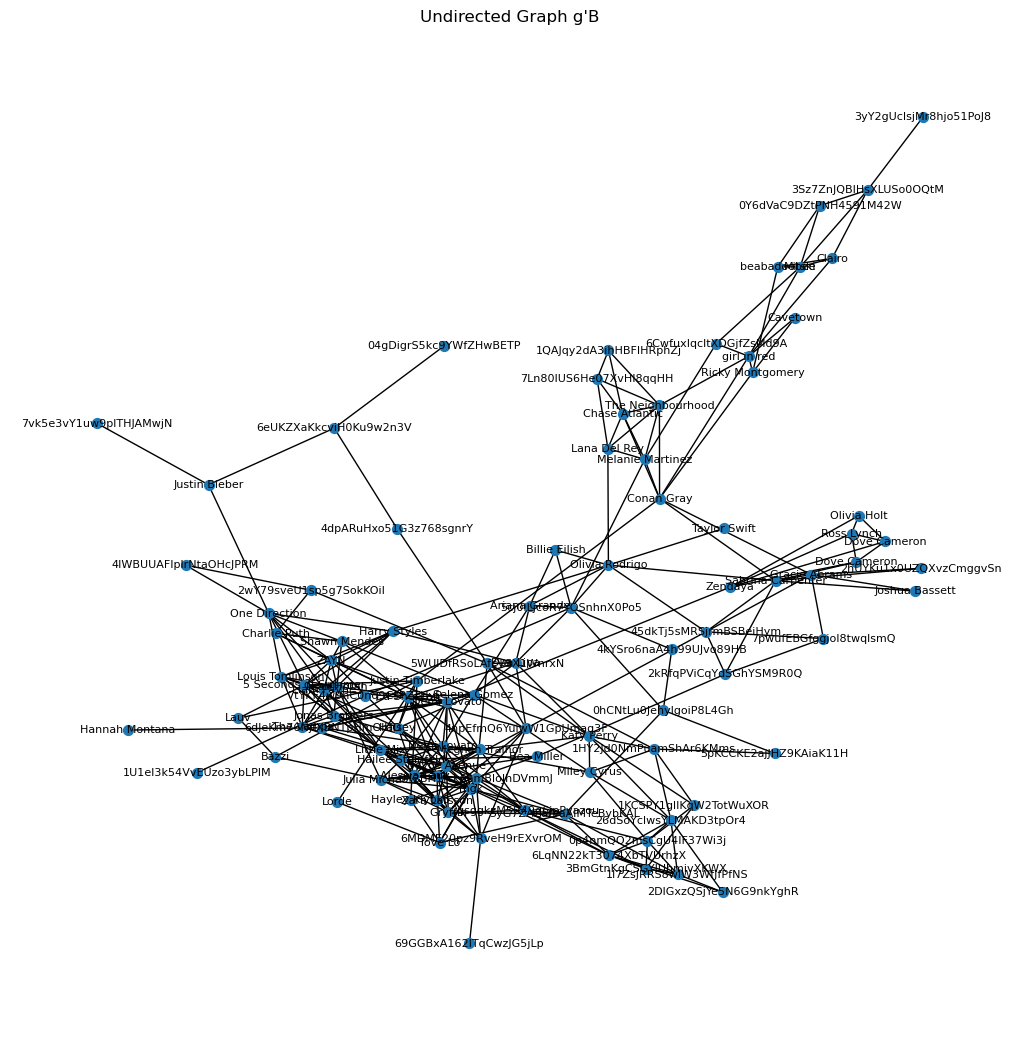

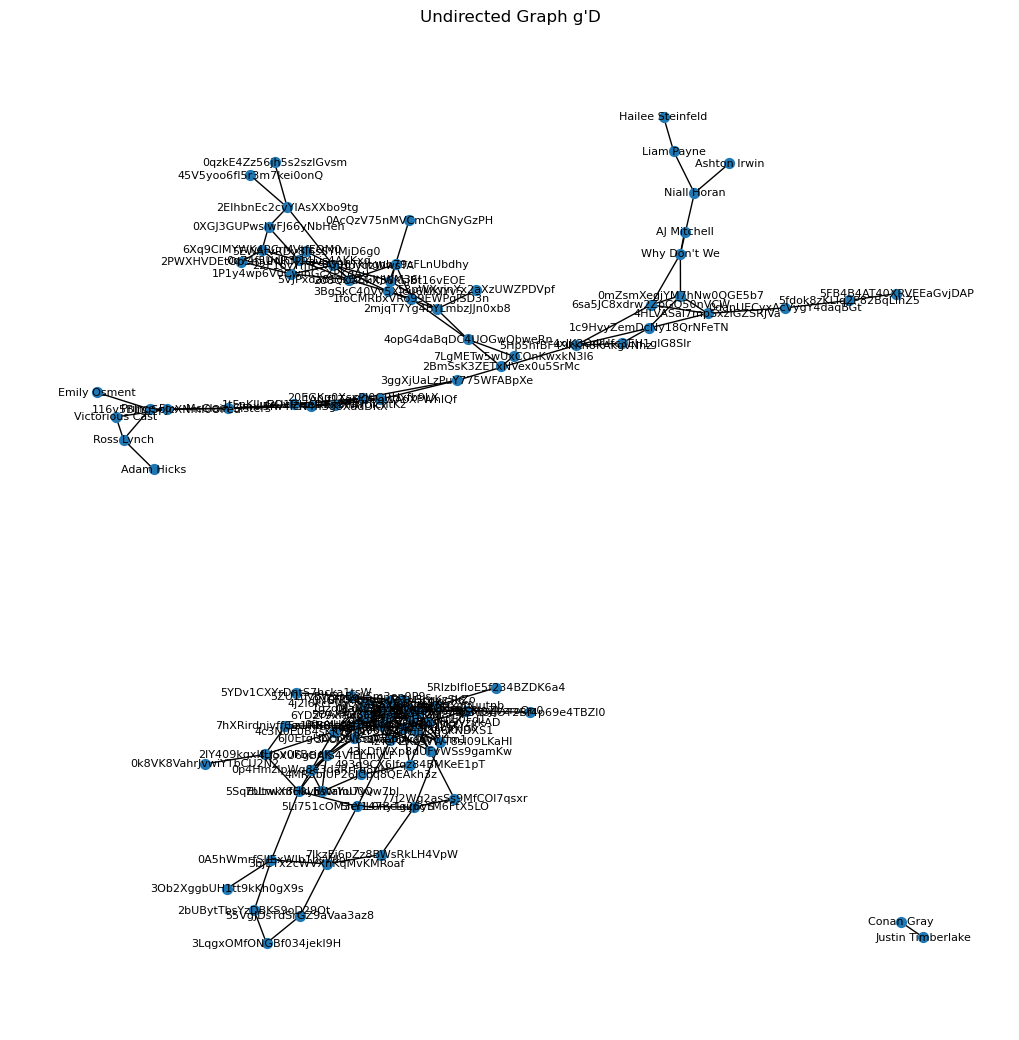

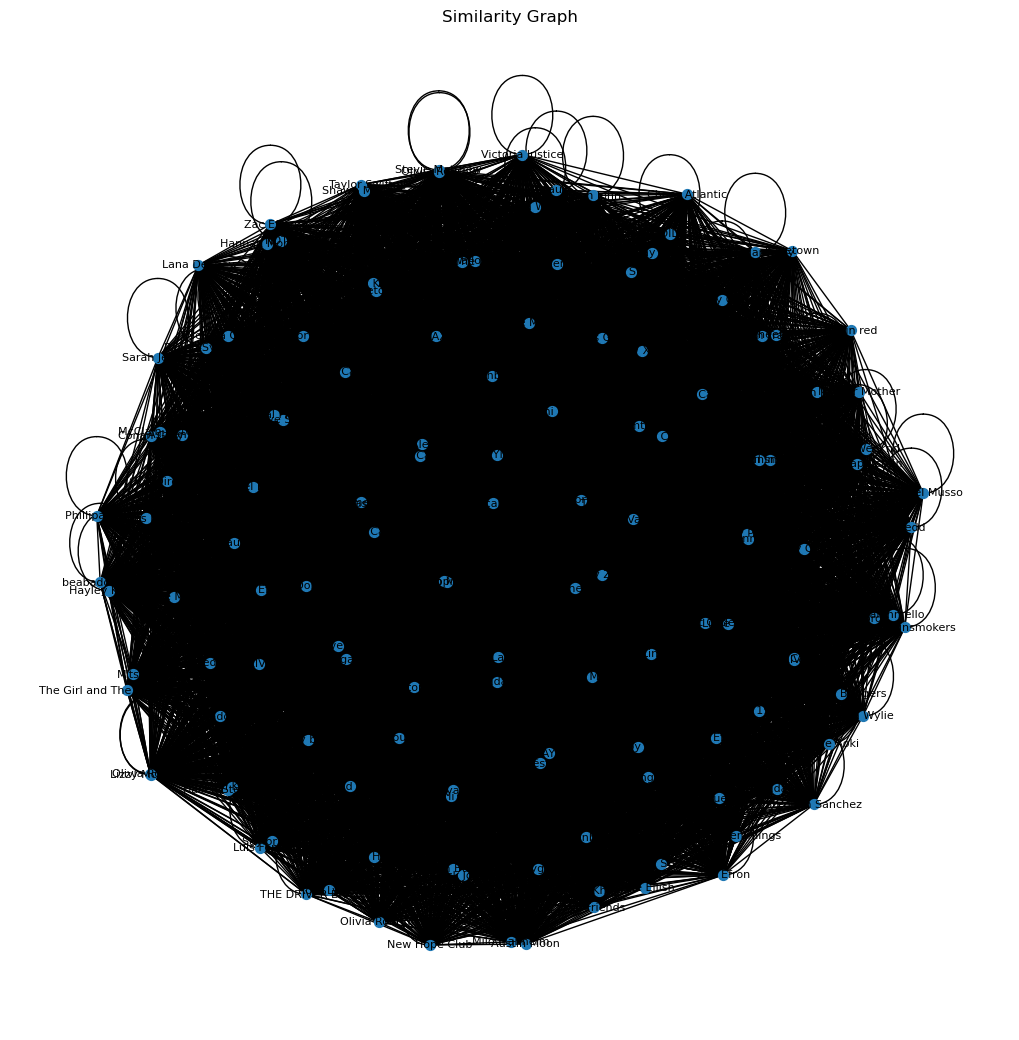

Metrics for Undirected Graph g'B:
Connected components: 1
Metrics for Undirected Graph g'D:
Connected components: 4
Metrics for Similarity Graph:
Connected components: 1
Debug: Most similar edge weight: 0.9999913066533639
Debug: Least similar edge weight: 0.999847611985269
Most similar artists: Lana Del Rey and Taylor Swift with weight 0.9999913066533639
Least similar artists: Hannah Montana and Mitchel Musso with weight 0.999847611985269
Artist most similar to all others: Hailee Steinfeld
Artist least similar to all others: Phillipa Soo


In [4]:
def main():
    # Load the graphs
    gB = nx.read_graphml('/Users/marino/Documents/GitHub/Analysis-of-music-networks/P1: Acquisition and storage of data/gB.graphml')
    gD = nx.read_graphml('/Users/marino/Documents/GitHub/Analysis-of-music-networks/P1: Acquisition and storage of data/gD.graphml')

    # Load tracks data 
    tracks_df = pd.read_csv('/Users/marino/Documents/GitHub/Analysis-of-music-networks/P1: Acquisition and storage of data/songs.csv')
    tracks_df = pd.DataFrame(tracks_df)

    # Task 6(a): Generate undirected graphs g'B and g'D
    gB_undirected = retrieve_bidirectional_edges(gB, tracks_df, '/Users/marino/Documents/GitHub/Analysis-of-music-networks/P2: Data Preprocessing/gBp.graphml')
    gD_undirected = retrieve_bidirectional_edges(gD, tracks_df, '/Users/marino/Documents/GitHub/Analysis-of-music-networks/P2: Data Preprocessing/gDp.graphml')

    # Task 6(b): Compute mean audio features
    mean_audio_features_df = compute_mean_audio_features(tracks_df)
    print(mean_audio_features_df)

    # Create similarity graph
    similarity_graph = create_similarity_graph(mean_audio_features_df, 'cosine', '/Users/marino/Documents/GitHub/Analysis-of-music-networks/P2: Data Preprocessing/gw.graphml')
    print("Graphs have been processed and saved successfully.")

    # Visualize the graphs
    visualize_graph(gB_undirected, "Undirected Graph g'B")
    visualize_graph(gD_undirected, "Undirected Graph g'D")
    visualize_graph(similarity_graph, "Similarity Graph")

    # Print metrics for each graph
    print_graph_metrics(gB_undirected, "Undirected Graph g'B")
    print_graph_metrics(gD_undirected, "Undirected Graph g'D")
    print_graph_metrics(similarity_graph, "Similarity Graph")

    # Find and print the most and least similar artists
    most_similar, least_similar = find_most_least_similar_artists(similarity_graph)
    print(f"Most similar artists: {similarity_graph.nodes[most_similar[0]]['name']} and {similarity_graph.nodes[most_similar[1]]['name']} with weight {most_similar[2]['weight']}")
    print(f"Least similar artists: {similarity_graph.nodes[least_similar[0]]['name']} and {similarity_graph.nodes[least_similar[1]]['name']} with weight {least_similar[2]['weight']}")

    # Find and print the artist most and least similar to all others
    most_similar_to_all, least_similar_to_all = find_most_least_similar_to_all(similarity_graph)
    print(f"Artist most similar to all others: {similarity_graph.nodes[most_similar_to_all]['name']}")
    print(f"Artist least similar to all others: {similarity_graph.nodes[least_similar_to_all]['name']}")

if __name__ == "__main__":
    main()


                  artist_id     artist_name  danceability    energy  loudness  \
0    00FQb4jTyendYWaN8pK0wa    Lana Del Rey      0.418700  0.521200 -8.291200   
1    06HL4z0CvFAxyc27GXpf02    Taylor Swift      0.567400  0.521500 -8.928900   
2    0C8ZW7ezQVs4URX5aX7Kqx            Kygo      0.640000  0.533000 -6.596000   
3    0C8ZW7ezQVs4URX5aX7Kqx            Rema      0.801000  0.806000 -5.206000   
4    0C8ZW7ezQVs4URX5aX7Kqx    Selena Gomez      0.659625  0.599000 -5.861875   
..                      ...             ...           ...       ...       ...   
338  7gbmX8SsfjEjxDMzBi1ZOL     Kevin Jonas      0.605000  0.846000 -4.581000   
339  7n2wHs1TKAczGzO7Dd2rGr    Shawn Mendes      0.641900  0.721200 -5.284500   
340  7nU4hB040gTmHm45YYMvqc  Hannah Montana      0.573000  0.852800 -3.798400   
341  7rPQ2z1ji1ctJ6oGYBAo6M    Emily Osment      0.600333  0.719889 -5.810889   
342  7rPQ2z1ji1ctJ6oGYBAo6M   Mitchel Musso      0.725000  0.836000 -5.885000   

     speechiness  acousticn

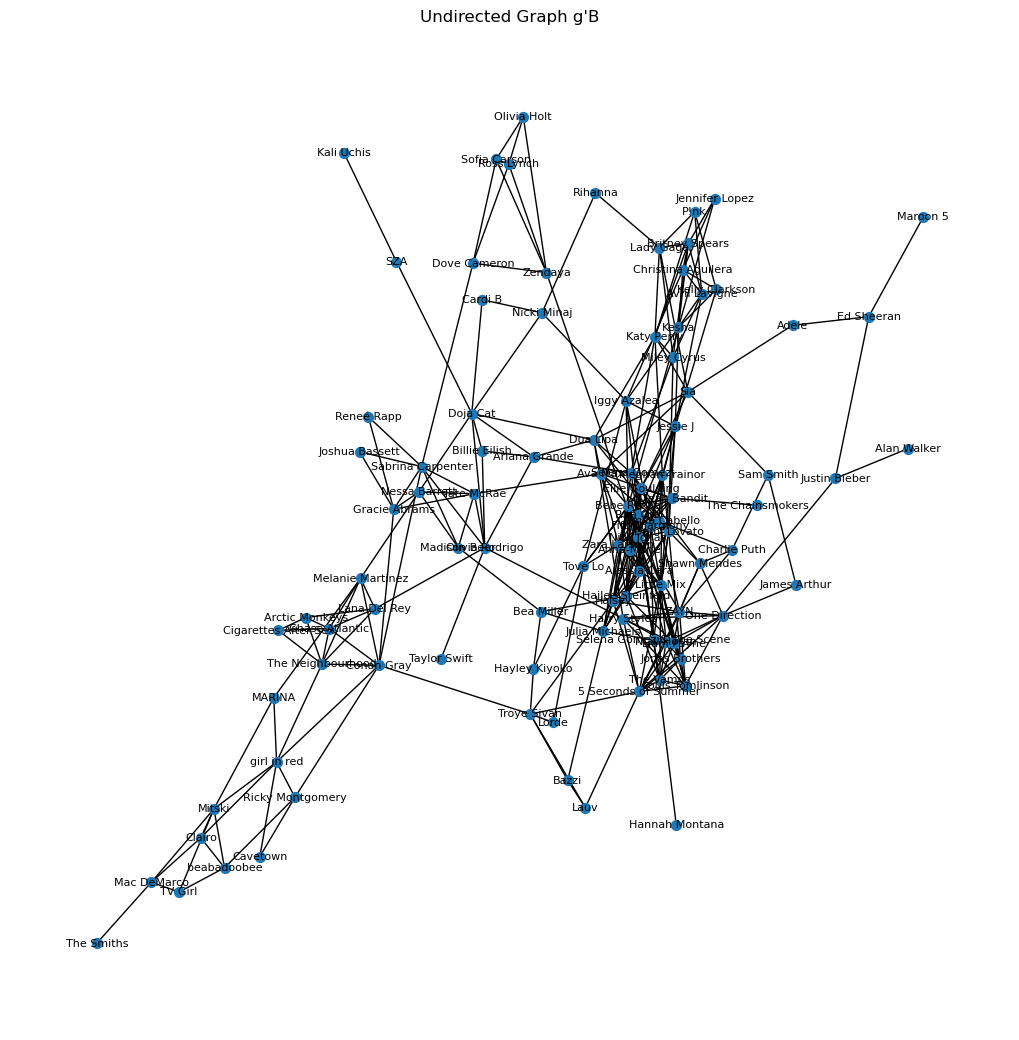

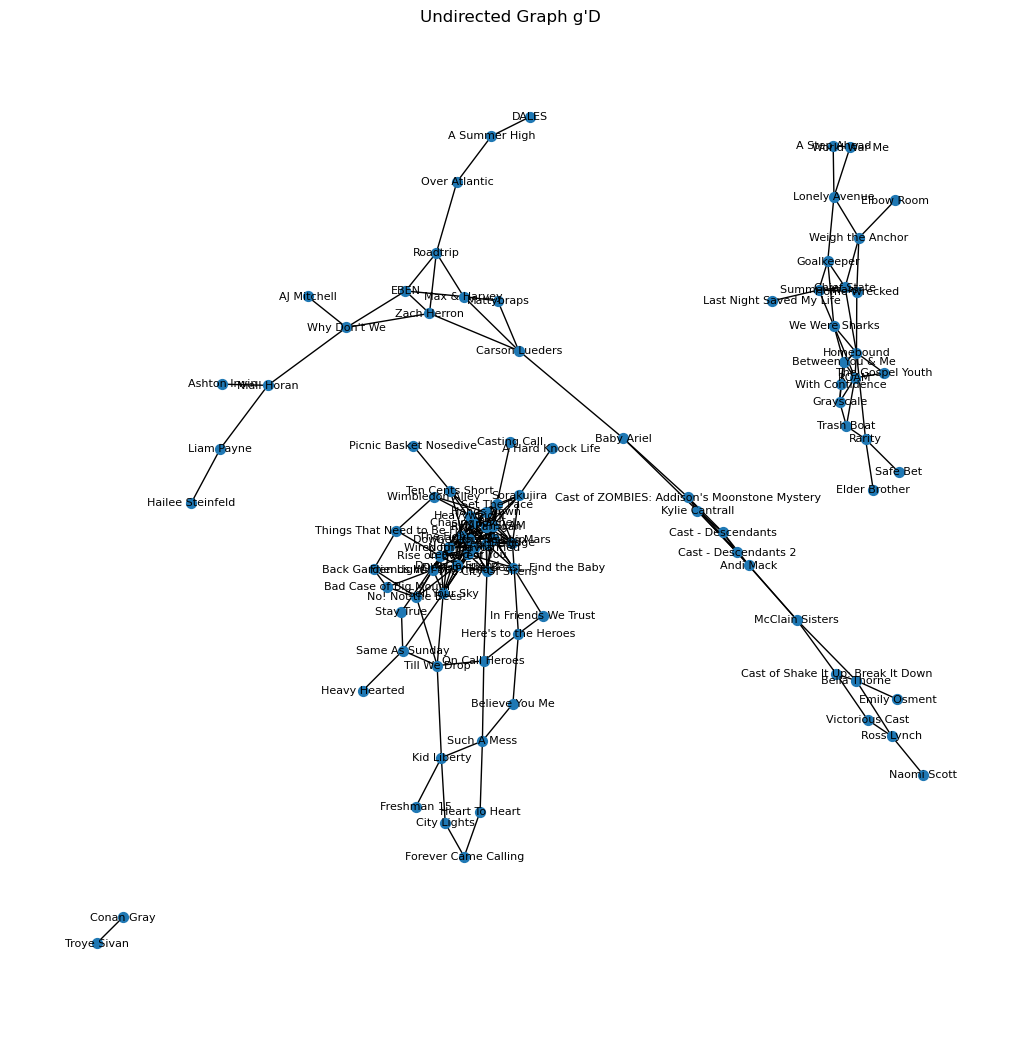

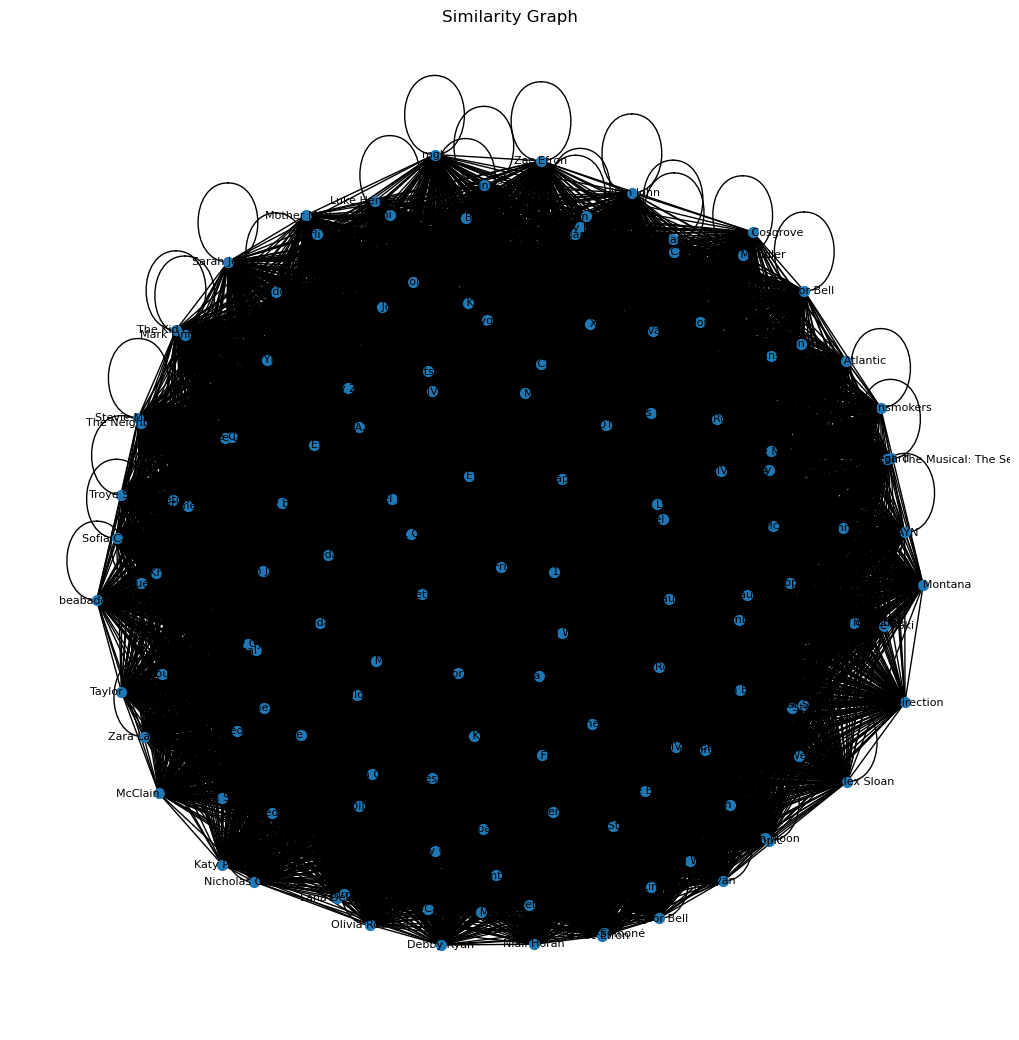

Metrics for Undirected Graph g'B:
Connected components: 1
Metrics for Undirected Graph g'D:
Connected components: 4
Metrics for Similarity Graph:
Connected components: 1
Debug: Most similar edge weight: 0.9999913066533639
Debug: Least similar edge weight: 0.999847611985269
Most similar artists: Lana Del Rey and Taylor Swift with weight 0.9999913066533639
Least similar artists: Hannah Montana and Mitchel Musso with weight 0.999847611985269
Artist most similar to all others: Hailee Steinfeld
Artist least similar to all others: Phillipa Soo


In [5]:
import networkx as nx
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import matplotlib.pyplot as plt

def retrieve_bidirectional_edges(g: nx.DiGraph, out_filename: str) -> nx.Graph:
    undirected_g = nx.Graph()
    
    for u, v in g.edges():
        if g.has_edge(v, u):
            undirected_g.add_edge(u, v)
    
    for node in undirected_g.nodes():
        if 'name' not in g.nodes[node]:
            undirected_g.nodes[node]['name'] = node
        else:
            undirected_g.nodes[node]['name'] = g.nodes[node]['name']
    
    nx.write_graphml(undirected_g, out_filename)
    
    return undirected_g

def prune_low_weight_edges(g: nx.Graph, min_weight: float = None, min_percentile: int = None, out_filename: str = None) -> nx.Graph:
    if (min_weight is None and min_percentile is None) or (min_weight is not None and min_percentile is not None):
        raise ValueError("Specify either min_weight or min_percentile, but not both.")
    
    if min_percentile is not None:
        weights = [data['weight'] for u, v, data in g.edges(data=True)]
        threshold = pd.Series(weights).quantile(min_percentile / 100)
    else:
        threshold = min_weight
    
    edges_to_keep = [(u, v) for u, v, data in g.edges(data=True) if data['weight'] >= threshold]
    pruned_g = g.edge_subgraph(edges_to_keep).copy()
    
    zero_degree_nodes = [node for node, degree in dict(pruned_g.degree()).items() if degree == 0]
    pruned_g.remove_nodes_from(zero_degree_nodes)
    
    for node in pruned_g.nodes():
        if 'name' not in g.nodes[node]:
            pruned_g.nodes[node]['name'] = node
        else:
            pruned_g.nodes[node]['name'] = g.nodes[node]['name']
    
    if out_filename:
        nx.write_graphml(pruned_g, out_filename)
    return pruned_g

def compute_mean_audio_features(tracks_df: pd.DataFrame) -> pd.DataFrame:
    audio_feature_columns = ['danceability', 'energy', 'loudness', 'speechiness',
                             'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
    
    mean_features_df = tracks_df.groupby(['artist_id', 'artist_name'])[audio_feature_columns].mean().reset_index()
    return mean_features_df

def create_similarity_graph(artist_audio_features_df: pd.DataFrame, similarity: str, out_filename: str = None) -> nx.Graph:
    feature_columns = artist_audio_features_df.select_dtypes(include='number').columns
    
    if similarity == "cosine":
        similarity_matrix = cosine_similarity(artist_audio_features_df[feature_columns])
    elif similarity == "euclidean":
        similarity_matrix = euclidean_distances(artist_audio_features_df[feature_columns])
        similarity_matrix = 1 / (1 + similarity_matrix)
    else:
        raise ValueError("Unknown similarity metric. Use 'cosine' or 'euclidean'.")
    
    similarity_graph = nx.Graph()
    num_artists = artist_audio_features_df.shape[0]
    
    for i in range(num_artists):
        for j in range(i + 1, num_artists):
            if i != j:  # Avoid self-loops
                similarity_graph.add_edge(artist_audio_features_df.iloc[i, 0], artist_audio_features_df.iloc[j, 0],
                                          weight=similarity_matrix[i, j])
                similarity_graph.nodes[artist_audio_features_df.iloc[i, 0]]['name'] = artist_audio_features_df.iloc[i, 1]
                similarity_graph.nodes[artist_audio_features_df.iloc[j, 0]]['name'] = artist_audio_features_df.iloc[j, 1]
    
    if out_filename:
        nx.write_graphml(similarity_graph, out_filename)
    
    return similarity_graph

def visualize_graph(graph, title):
    pos = nx.spring_layout(graph)
    plt.figure(figsize=(10, 10))
    labels = nx.get_node_attributes(graph, 'name')
    nx.draw(graph, pos, labels=labels, with_labels=True, node_size=50, font_size=8)
    plt.title(title)
    plt.show()

def print_graph_metrics(graph, name):
    print(f"Metrics for {name}:")
    if nx.is_directed(graph):
        print(f"Strongly connected components: {nx.number_strongly_connected_components(graph)}")
        print(f"Weakly connected components: {nx.number_weakly_connected_components(graph)}")
    else:
        print(f"Connected components: {nx.number_connected_components(graph)}")

def find_most_least_similar_artists(graph):
    edges = sorted((u, v, d) for u, v, d in graph.edges(data=True) if u != v)  # Exclude self-loops
    most_similar = edges[0]
    least_similar = edges[-1]
    print(f"Debug: Most similar edge weight: {most_similar[2]['weight']}")
    print(f"Debug: Least similar edge weight: {least_similar[2]['weight']}")
    return most_similar, least_similar

def find_most_least_similar_to_all(graph):
    avg_weights = {node: sum(data['weight'] for _, _, data in graph.edges(node, data=True)) / graph.degree(node) 
                   for node in graph.nodes()}
    most_similar = max(avg_weights, key=avg_weights.get)
    least_similar = min(avg_weights, key=avg_weights.get)
    return most_similar, least_similar

def main():
    # Load the graphs
    gB = nx.read_graphml('/Users/marino/Documents/GitHub/Analysis-of-music-networks/P1: Acquisition and storage of data/gB.graphml')
    gD = nx.read_graphml('/Users/marino/Documents/GitHub/Analysis-of-music-networks/P1: Acquisition and storage of data/gD.graphml')

    # Load tracks data 
    tracks_df = pd.read_csv('/Users/marino/Documents/GitHub/Analysis-of-music-networks/P1: Acquisition and storage of data/songs.csv')
    tracks_df = pd.DataFrame(tracks_df)

    # Task 6(a): Generate undirected graphs g'B and g'D
    gB_undirected = retrieve_bidirectional_edges(gB, '/Users/marino/Documents/GitHub/Analysis-of-music-networks/P2: Data Preprocessing/gBp.graphml')
    gD_undirected = retrieve_bidirectional_edges(gD, '/Users/marino/Documents/GitHub/Analysis-of-music-networks/P2: Data Preprocessing/gDp.graphml')

    # Task 6(b): Compute mean audio features
    mean_audio_features_df = compute_mean_audio_features(tracks_df)
    print(mean_audio_features_df)

    # Create similarity graph
    similarity_graph = create_similarity_graph(mean_audio_features_df, 'cosine', '/Users/marino/Documents/GitHub/Analysis-of-music-networks/P2: Data Preprocessing/gw.graphml')
    print("Graphs have been processed and saved successfully.")

    # Visualize the graphs
    visualize_graph(gB_undirected, "Undirected Graph g'B")
    visualize_graph(gD_undirected, "Undirected Graph g'D")
    visualize_graph(similarity_graph, "Similarity Graph")

    # Print metrics for each graph
    print_graph_metrics(gB_undirected, "Undirected Graph g'B")
    print_graph_metrics(gD_undirected, "Undirected Graph g'D")
    print_graph_metrics(similarity_graph, "Similarity Graph")

    # Find and print the most and least similar artists
    most_similar, least_similar = find_most_least_similar_artists(similarity_graph)
    print(f"Most similar artists: {similarity_graph.nodes[most_similar[0]]['name']} and {similarity_graph.nodes[most_similar[1]]['name']} with weight {most_similar[2]['weight']}")
    print(f"Least similar artists: {similarity_graph.nodes[least_similar[0]]['name']} and {similarity_graph.nodes[least_similar[1]]['name']} with weight {least_similar[2]['weight']}")

    # Find and print the artist most and least similar to all others
    most_similar_to_all, least_similar_to_all = find_most_least_similar_to_all(similarity_graph)
    print(f"Artist most similar to all others: {similarity_graph.nodes[most_similar_to_all]['name']}")
    print(f"Artist least similar to all others: {similarity_graph.nodes[least_similar_to_all]['name']}")

if __name__ == "__main__":
    main()


# Final con metrics

                  artist_id     artist_name  danceability    energy  loudness  \
0    00FQb4jTyendYWaN8pK0wa    Lana Del Rey      0.418700  0.521200 -8.291200   
1    06HL4z0CvFAxyc27GXpf02    Taylor Swift      0.567400  0.521500 -8.928900   
2    0C8ZW7ezQVs4URX5aX7Kqx            Kygo      0.640000  0.533000 -6.596000   
3    0C8ZW7ezQVs4URX5aX7Kqx            Rema      0.801000  0.806000 -5.206000   
4    0C8ZW7ezQVs4URX5aX7Kqx    Selena Gomez      0.659625  0.599000 -5.861875   
..                      ...             ...           ...       ...       ...   
338  7gbmX8SsfjEjxDMzBi1ZOL     Kevin Jonas      0.605000  0.846000 -4.581000   
339  7n2wHs1TKAczGzO7Dd2rGr    Shawn Mendes      0.641900  0.721200 -5.284500   
340  7nU4hB040gTmHm45YYMvqc  Hannah Montana      0.573000  0.852800 -3.798400   
341  7rPQ2z1ji1ctJ6oGYBAo6M    Emily Osment      0.600333  0.719889 -5.810889   
342  7rPQ2z1ji1ctJ6oGYBAo6M   Mitchel Musso      0.725000  0.836000 -5.885000   

     speechiness  acousticn

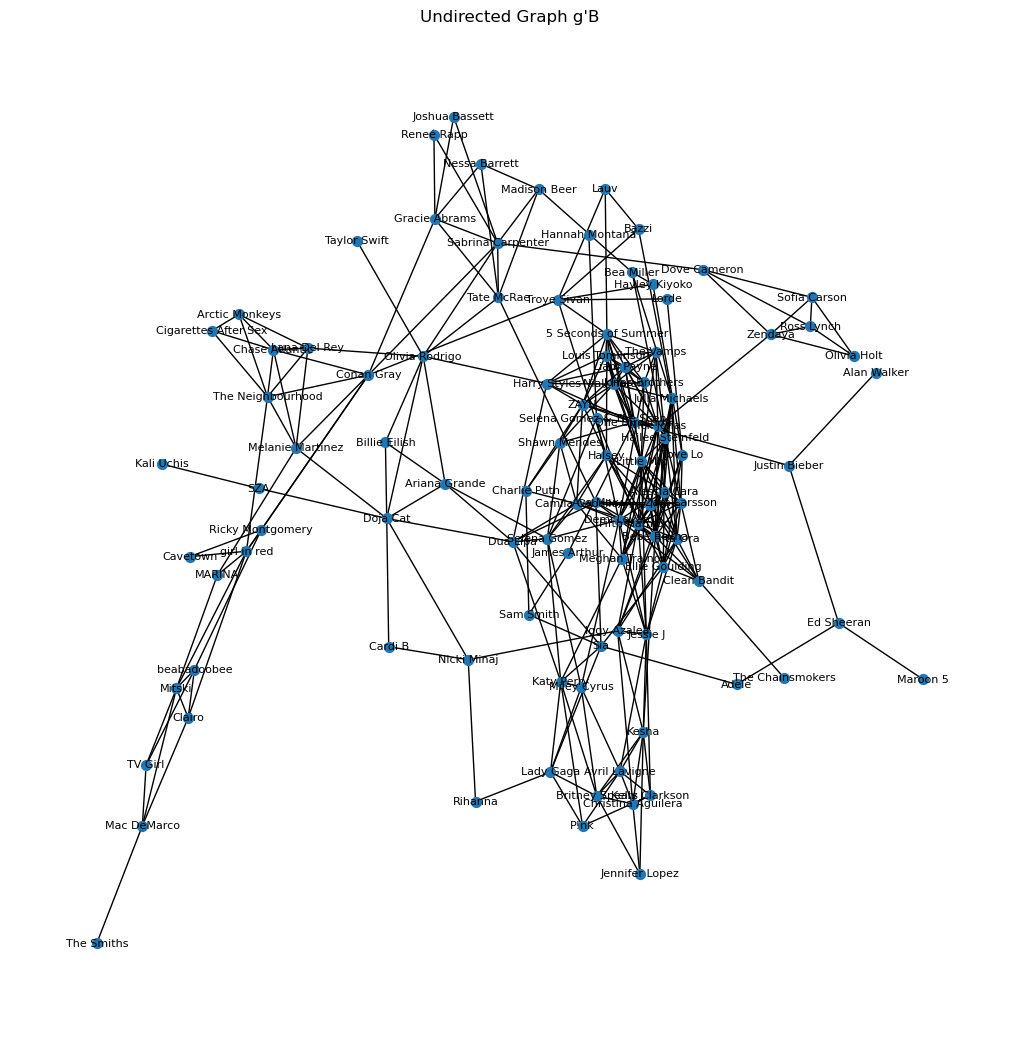

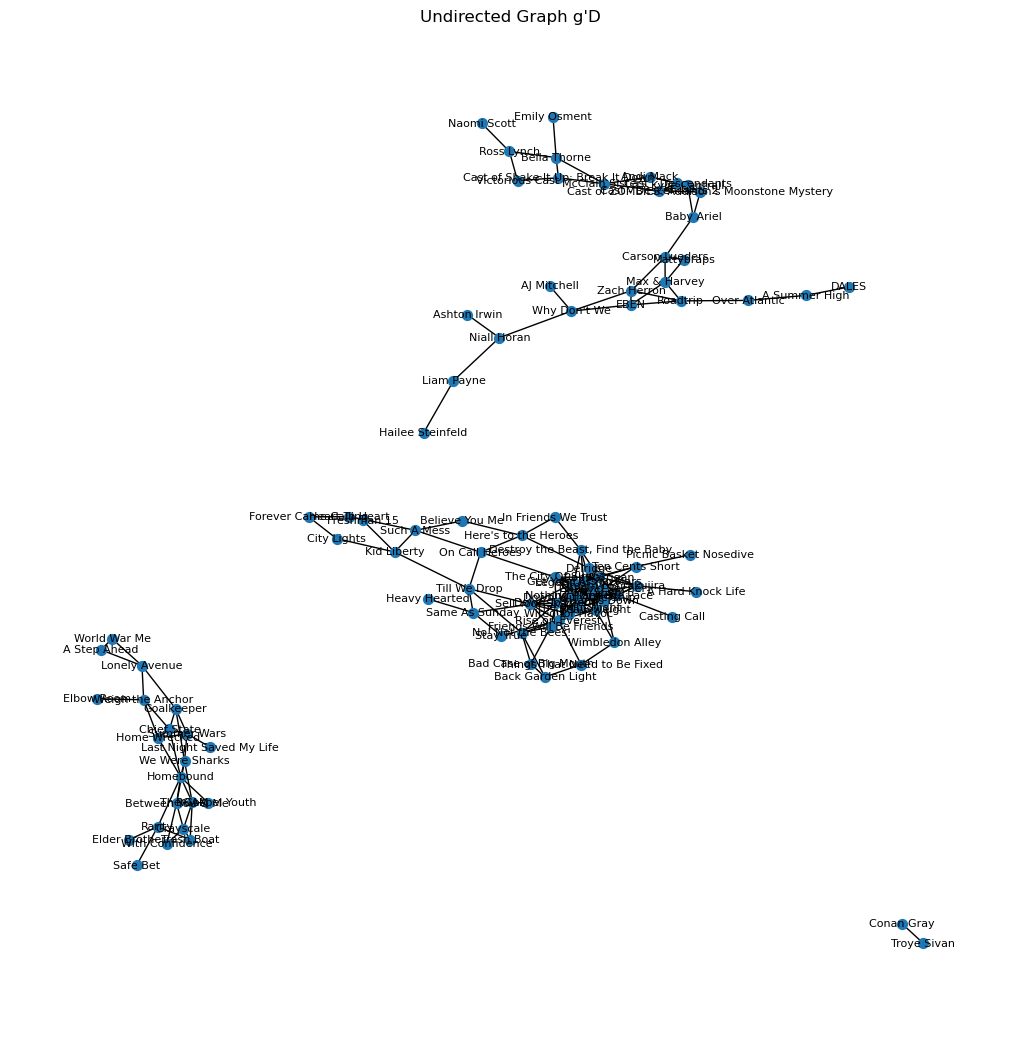

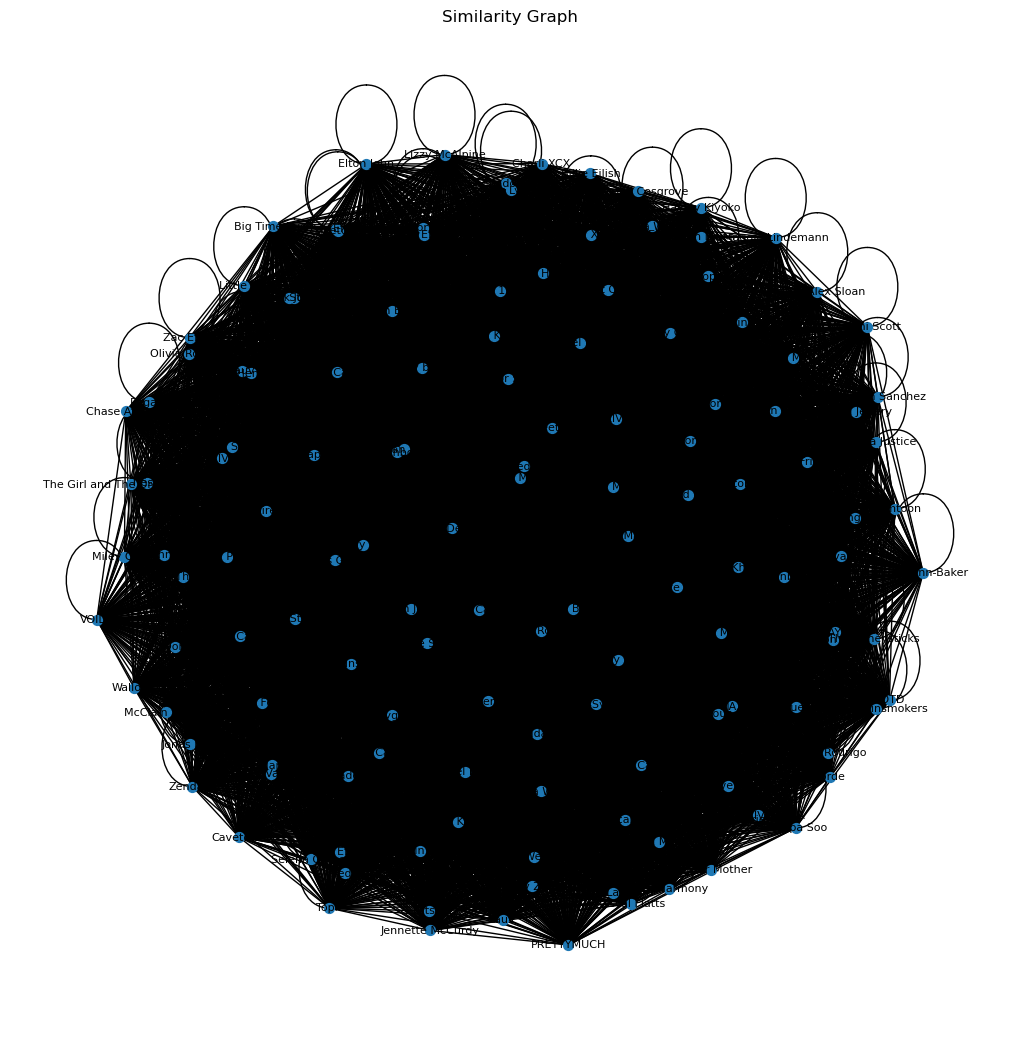

Metrics for Undirected Graph g'B:
Order (number of nodes): 99
Size (number of edges): 307
Density: 0.0633
Connected components: 1
Metrics for Undirected Graph g'D:
Order (number of nodes): 95
Size (number of edges): 221
Density: 0.0495
Connected components: 4
Metrics for Similarity Graph:
Order (number of nodes): 138
Size (number of edges): 9547
Density: 1.0099
Connected components: 1
Debug: Most similar edge weight: 0.9999913066533639
Debug: Least similar edge weight: 0.999847611985269
Most similar artists: Lana Del Rey and Taylor Swift with weight 0.9999913066533639
Least similar artists: Hannah Montana and Mitchel Musso with weight 0.999847611985269
Artist most similar to all others: Hailee Steinfeld
Artist least similar to all others: Phillipa Soo


In [6]:
import networkx as nx
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import matplotlib.pyplot as plt

def retrieve_bidirectional_edges(g: nx.DiGraph, out_filename: str) -> nx.Graph:
    """
    Convert a directed graph into an undirected graph by considering bidirectional edges only.

    :param g: a networkx digraph.
    :param out_filename: name of the file that will be saved.
    :return: a networkx undirected graph.
    """
    
    undirected_g = nx.Graph()
    
    for u, v in g.edges():
        if g.has_edge(v, u):
            undirected_g.add_edge(u, v)
    
    for node in undirected_g.nodes():
        if 'name' not in g.nodes[node]:
            undirected_g.nodes[node]['name'] = node
        else:
            undirected_g.nodes[node]['name'] = g.nodes[node]['name']
    
    nx.write_graphml(undirected_g, out_filename)
    
    return undirected_g

def prune_low_degree_nodes(g: nx.Graph, min_degree: int, out_filename: str) -> nx.Graph:
    """
    Prune a graph by removing nodes with degree < min_degree.

    :param g: a networkx graph.
    :param min_degree: lower bound value for the degree.
    :param out_filename: name of the file that will be saved.
    :return: a pruned networkx graph.
    """
    nodes_to_keep = [node for node, degree in dict(g.degree()).items() if degree >= min_degree]
    pruned_g = g.subgraph(nodes_to_keep).copy()

    nx.write_graphml(pruned_g, out_filename)
    return pruned_g

def prune_low_weight_edges(g: nx.Graph, min_weight: float = None, min_percentile: int = None, out_filename: str = None) -> nx.Graph:
    """
    Prune a graph by removing edges with weight < threshold. Threshold can be specified as a value or as a percentile.

    :param g: a weighted networkx graph.
    :param min_weight: lower bound value for the weight.
    :param min_percentile: lower bound percentile for the weight.
    :param out_filename: name of the file that will be saved.
    :return: a pruned networkx graph.
    """
    
    if (min_weight is None and min_percentile is None) or (min_weight is not None and min_percentile is not None):
        raise ValueError("Specify either min_weight or min_percentile, but not both.")
    
    if min_percentile is not None:
        weights = [data['weight'] for u, v, data in g.edges(data=True)]
        threshold = pd.Series(weights).quantile(min_percentile / 100)
    else:
        threshold = min_weight
    
    edges_to_keep = [(u, v) for u, v, data in g.edges(data=True) if data['weight'] >= threshold]
    pruned_g = g.edge_subgraph(edges_to_keep).copy()
    
    zero_degree_nodes = [node for node, degree in dict(pruned_g.degree()).items() if degree == 0]
    pruned_g.remove_nodes_from(zero_degree_nodes)
    
    for node in pruned_g.nodes():
        if 'name' not in g.nodes[node]:
            pruned_g.nodes[node]['name'] = node
        else:
            pruned_g.nodes[node]['name'] = g.nodes[node]['name']
    
    if out_filename:
        nx.write_graphml(pruned_g, out_filename)
    return pruned_g

def compute_mean_audio_features(tracks_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute the mean audio features for tracks of the same artist.

    :param tracks_df: tracks dataframe (with audio features per each track).
    :return: artist dataframe (with mean audio features per each artist).
    """
    audio_feature_columns = ['danceability', 'energy', 'loudness', 'speechiness',
                             'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
    
    mean_features_df = tracks_df.groupby(['artist_id', 'artist_name'])[audio_feature_columns].mean().reset_index()
    return mean_features_df

def create_similarity_graph(artist_audio_features_df: pd.DataFrame, similarity: str, out_filename: str = None) -> nx.Graph:
    """
    Create a similarity graph from a dataframe with mean audio features per artist.

    :param artist_audio_features_df: dataframe with mean audio features per artist.
    :param similarity: the name of the similarity metric to use (e.g. "cosine" or "euclidean").
    :param out_filename: name of the file that will be saved.
    :return: a networkx graph with the similarity between artists as edge weights.
    """
    feature_columns = artist_audio_features_df.select_dtypes(include='number').columns
    
    if similarity == "cosine":
        similarity_matrix = cosine_similarity(artist_audio_features_df[feature_columns])
    elif similarity == "euclidean":
        similarity_matrix = euclidean_distances(artist_audio_features_df[feature_columns])
        similarity_matrix = 1 / (1 + similarity_matrix)
    else:
        raise ValueError("Unknown similarity metric. Use 'cosine' or 'euclidean'.")
    
    similarity_graph = nx.Graph()
    num_artists = artist_audio_features_df.shape[0]
    
    for i in range(num_artists):
        for j in range(i + 1, num_artists):
            if i != j:  # Avoid self-loops
                similarity_graph.add_edge(artist_audio_features_df.iloc[i, 0], artist_audio_features_df.iloc[j, 0],
                                          weight=similarity_matrix[i, j])
                similarity_graph.nodes[artist_audio_features_df.iloc[i, 0]]['name'] = artist_audio_features_df.iloc[i, 1]
                similarity_graph.nodes[artist_audio_features_df.iloc[j, 0]]['name'] = artist_audio_features_df.iloc[j, 1]
    
    if out_filename:
        nx.write_graphml(similarity_graph, out_filename)
    
    return similarity_graph


# ------- IMPLEMENT HERE ANY AUXILIARY FUNCTIONS NEEDED ------- #
def visualize_graph(graph, title):
    pos = nx.spring_layout(graph)
    plt.figure(figsize=(10, 10))
    labels = nx.get_node_attributes(graph, 'name')
    nx.draw(graph, pos, labels=labels, with_labels=True, node_size=50, font_size=8)
    plt.title(title)
    plt.show()

def print_graph_metrics(graph, name):
    print(f"Metrics for {name}:")
    print(f"Order (number of nodes): {graph.number_of_nodes()}")
    print(f"Size (number of edges): {graph.number_of_edges()}")
    print(f"Density: {nx.density(graph):.4f}")
    if nx.is_directed(graph):
        print(f"Strongly connected components: {nx.number_strongly_connected_components(graph)}")
        print(f"Weakly connected components: {nx.number_weakly_connected_components(graph)}")
    else:
        print(f"Connected components: {nx.number_connected_components(graph)}")

def find_most_least_similar_artists(graph):
    edges = sorted((u, v, d) for u, v, d in graph.edges(data=True) if u != v)  # Exclude self-loops
    most_similar = edges[0]
    least_similar = edges[-1]
    print(f"Debug: Most similar edge weight: {most_similar[2]['weight']}")
    print(f"Debug: Least similar edge weight: {least_similar[2]['weight']}")
    return most_similar, least_similar

def find_most_least_similar_to_all(graph):
    avg_weights = {node: sum(data['weight'] for _, _, data in graph.edges(node, data=True)) / graph.degree(node) 
                   for node in graph.nodes()}
    most_similar = max(avg_weights, key=avg_weights.get)
    least_similar = min(avg_weights, key=avg_weights.get)
    return most_similar, least_similar
# --------------- END OF AUXILIARY FUNCTIONS ------------------ #

def main():
    # Load the graphs
    gB = nx.read_graphml('/Users/marino/Documents/GitHub/Analysis-of-music-networks/P1: Acquisition and storage of data/gB.graphml')
    gD = nx.read_graphml('/Users/marino/Documents/GitHub/Analysis-of-music-networks/P1: Acquisition and storage of data/gD.graphml')

    # Load tracks data 
    tracks_df = pd.read_csv('/Users/marino/Documents/GitHub/Analysis-of-music-networks/P1: Acquisition and storage of data/songs.csv')
    tracks_df = pd.DataFrame(tracks_df)

    # Task 6(a): Generate undirected graphs g'B and g'D
    gB_undirected = retrieve_bidirectional_edges(gB, '/Users/marino/Documents/GitHub/Analysis-of-music-networks/P2: Data Preprocessing/gBp.graphml')
    gD_undirected = retrieve_bidirectional_edges(gD, '/Users/marino/Documents/GitHub/Analysis-of-music-networks/P2: Data Preprocessing/gDp.graphml')

    # Task 6(b): Compute mean audio features
    mean_audio_features_df = compute_mean_audio_features(tracks_df)
    print(mean_audio_features_df)

    # Create similarity graph
    similarity_graph = create_similarity_graph(mean_audio_features_df, 'cosine', '/Users/marino/Documents/GitHub/Analysis-of-music-networks/P2: Data Preprocessing/gw.graphml')
    print("Graphs have been processed and saved successfully.")

    # Visualize the graphs
    visualize_graph(gB_undirected, "Undirected Graph g'B")
    visualize_graph(gD_undirected, "Undirected Graph g'D")
    visualize_graph(similarity_graph, "Similarity Graph")

    # Print metrics for each graph
    print_graph_metrics(gB_undirected, "Undirected Graph g'B")
    print_graph_metrics(gD_undirected, "Undirected Graph g'D")
    print_graph_metrics(similarity_graph, "Similarity Graph")

    # Find and print the most and least similar artists
    most_similar, least_similar = find_most_least_similar_artists(similarity_graph)
    print(f"Most similar artists: {similarity_graph.nodes[most_similar[0]]['name']} and {similarity_graph.nodes[most_similar[1]]['name']} with weight {most_similar[2]['weight']}")
    print(f"Least similar artists: {similarity_graph.nodes[least_similar[0]]['name']} and {similarity_graph.nodes[least_similar[1]]['name']} with weight {least_similar[2]['weight']}")

    # Find and print the artist most and least similar to all others
    most_similar_to_all, least_similar_to_all = find_most_least_similar_to_all(similarity_graph)
    print(f"Artist most similar to all others: {similarity_graph.nodes[most_similar_to_all]['name']}")
    print(f"Artist least similar to all others: {similarity_graph.nodes[least_similar_to_all]['name']}")

if __name__ == "__main__":
    main()
